In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')   # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Suyash@67',
    database='ecommerse'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'C:\Users\suyas\OneDrive\Documents\Data Analytics\project_1'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Suyash@67',
    database='ecommerse'
)
cursor = conn.cursor()

# List all unique cities where customers are located.

In [3]:
query = """ select distinct customer_city from customers """
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data)
df.head(5)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [4]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cursor.execute(query)
data = cursor.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 135303)

# Find the total sales per category.

In [5]:
query = """ select products.product_category category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["category", "sales"])
df

,category,sales
0,perfumery,6080863.92
1,Furniture Decoration,17162116.70
2,telephony,5842584.61
3,Fashion Bags and Accessories,2617899.36
4,bed table bath,20550644.05
...,...,...
69,cds music dvds,14393.16
70,La Cuisine,34962.36
71,Fashion Children's Clothing,9428.04
72,PC Gamer,26093.16


# Calculate the percentage of orders that were paid in installments.

In [6]:
query = """ select sum(case when payment_installments >= 1 then 1 else 0 end)/count(*)*100 from payments """
cursor.execute(query)
data = cursor.fetchall()
data

[(Decimal('99.9981'),)]

# Count the number of customers from each state.

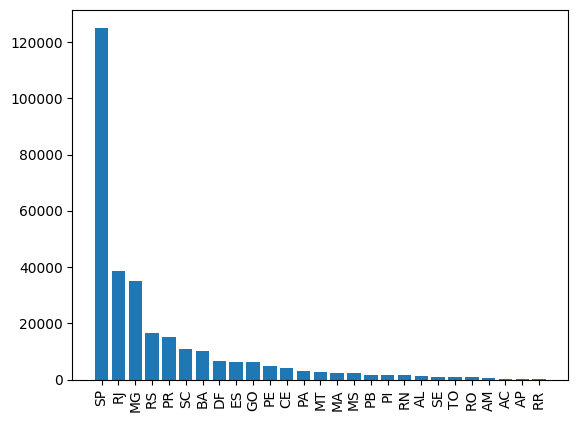

In [7]:
query = """ select customer_state, count(customer_id)
from customers
group by customer_state
ORDER BY COUNT(customer_id) DESC
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["state","customer_count"])
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)  # rotate names on x axis by 90 degree
plt.show()

# Calculate the number of orders per month in 2018.

      months  tot_order
0       July      18876
1     August      19536
2   February      20184
3       June      18501
4      March      21633
5    January      21807
6        May      20619
7      April      20817
8  September         48
9    October         12


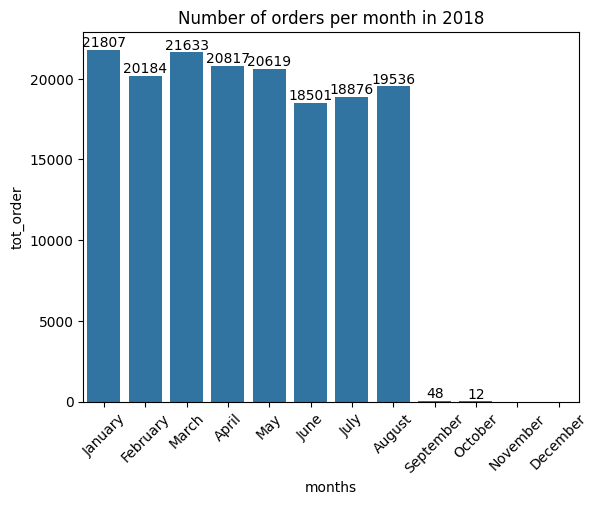

In [8]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) tot_order
from orders   
where year(order_purchase_timestamp) = 2018
group by months   
"""
# here we can also give name to monthname(order_purchase_timestamp) and use them instead of original column name everywhere
# example = select monthname(order_purchase_timestamp) month, count(order_id) tot_orders
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["months", "tot_order"])
print(df)
o = ["January","February","March","April","May","June","July","August","September","October","November","December"]
ax = sns.barplot(x = df["months"], y = df["tot_order"], data = df, order = o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Number of orders per month in 2018")
plt.show()


# Find the average number of products per order, grouped by customer city.

In [9]:
query = """ with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc)) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc """
cursor.execute(query)
data = cursor.fetchall()
df= pd.DataFrame(data, columns=["customer_city", "avg_product/order"])
df.head(10)

,customer_city,avg_product/order
0,padre carvalho,42
1,celso ramos,39
2,datas,36
3,candido godoi,36
4,matias olimpio,30
5,cidelandia,24
6,curralinho,24
7,picarra,24
8,morro de sao paulo,24
9,teixeira soares,24


# Calculate the percentage of total revenue contributed by each product category

In [10]:
query = """ select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["category", "sales_percentage"])
df

,category,sales_percentage
0,BED TABLE BATH,64.0
1,HEALTH BEAUTY,62.0
2,COMPUTER ACCESSORIES,59.0
3,FURNITURE DECORATION,54.0
4,WATCHES PRESENT,54.0
...,...,...
69,CDS MUSIC DVDS,0.0
70,LA CUISINE,0.0
71,FASHION CHILDREN'S CLOTHING,0.0
72,PC GAMER,0.0


# Identify the correlation between product price and the number of times a product has been purchased.

In [11]:
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157569
